<a href="https://colab.research.google.com/github/itzem-vg/Practicos-SIS420-COM200/blob/main/LAB6/v1.0_Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


###LAB 6
INTEGRANTES:
- Aly Delgado Danner Abel - Ing. de Sistemas
- Julio Cesar Ortega Albarado - Ing. de Sistemas
- Itzel Emily Velasquez Guerra - Ing. En diseño y animación digital
- Rojas Vasquez Sheila - Ing. de Sistemas
- Lujan Renteria David Fernando - Ing. Ciencias de la Computación


#  Blackjack
El [blackjack](https://https://gymnasium.farama.org/environments/toy_text/blackjack/) es un juego de cartas en el que el objetivo es vencer al crupier obteniendo cartas cuya suma se acerque más a 21 (sin pasarse de 21) que las cartas del crupier.

##Espacio de Acción
`Discrete(2)`

Este espacio significa que hay dos acciones posibles que el agente puede realizar en cada turno:


*    [0] "Plantarse" o "Stand"— El jugador decide no tomar más cartas.
*  [1] "Pedir carta" o "Hit" — El jugador toma una carta adicional.

--------------------------------------------------------------------------
##Espacio de Observación
`Tuple(Discrete(32), Discrete(11), Discrete(2))`

Este espacio de observación está estructurado como una tupla de tres valores discretos, que describe el estado actual del juego desde la perspectiva del agente (el jugador):

- `Discrete(32)`:suma total de puntos del jugador, desde un mínimo hasta un máximo de 32 puntos. Aunque el valor máximo en Blackjack es 21, este rango cubre valores superiores para representar situaciones en las que el jugador puede “pasarse” de 21.

- `Discrete(11)`: Representa el valor de la carta expuesta del crupier, de 1 a 10. Aquí, el valor 1 se refiere a un As, que puede contar como 1 o 11 según la situación.

- `Discrete(2)`: Indica si el jugador tiene un As utilizable en su mano:

*[0] : No tiene un As utilizable (un As que cuente como 11).*

*[1]: Tiene un As utilizable.*

# Ecuación de Q-learning
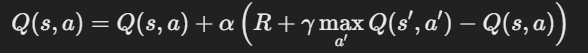

Q ( s ,a ):El valor En el estados.

alfa
alfa: La tasa de aprendizaje , un valor entre 0 y 1 que determina cuánto peso se da a la nueva información. Un valor más alto de alfa
alfaimplica que el agente aprenderá rápidamente, pero puede hacerlo de forma menos estable.

R: La recompensa obtenida después de tomar la acción a En el estado


gamma: El factor de descuento (factor de descuento), también entre 0 y 1, que pondera las recompensas futuras. Naciones Unidas gamma
- gamma cercano a 1 hace que el agente valore mucho las recompensas futuras
- un valor cercano a 0 hace que se enfoque en recompensas inmediatas.
máximo
⁡
a
"
Q
(
s
"
,
a
"
)
máximo
a
"

​
 Q ( s)
"
 ,a
"
 ): El valor máximo esperado de la acción óptima en el siguiente estado
s
"
s
"
 . Este término permite que el agente aprenda la mejor estrategia posible a largo plazo, ya que siempre se actualiza considerando la mejor acción futura en el siguiente estado.

In [ ]:
# import gymnasium as gym

# # Initialise the environment
# env = gym.make("Blackjack-v1", render_mode="human")

# # Reset the environment to generate the first observation
# observation, info = env.reset(seed=42)
# for _ in range(1000):
#     # this is where you would insert your policy
#     action = env.action_space.sample()

#     # step (transition) through the environment with the action
#     # receiving the next observation, reward and if the episode has terminated or truncated
#     observation, reward, terminated, truncated, info = env.step(action)

#     # If the episode has ended then we can reset to start a new episode
#     if terminated or truncated:
#         observation, info = env.reset()

# env.close()

In [ ]:
%matplotlib inline

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import pickle  # Guardar una tabla que el agente usa para recordar sus decisiones
"""
-------------------------------------------------------------------------------------------
"""

# Inicializar el entorno
env = gym.make("Blackjack-v1", natural=False, render_mode="human")
"""
render_mode="human" -> permite visualizar el entorno.
natural=False  -> desactiva la regla de “blackjack natural” (21 con un As y una carta de valor 10) es el mejor inicio posible y usualmente resulta en una victoria automática.
-------------------------------------------------------------------------------------------
"""


# Parámetros de Q-learning
alpha = 0.1     # Tasa de aprendizaje -> cuánto se actualizan los valores en la Q-table después de cada paso.
gamma = 0.99    # Factor de descuento -> determina cuánto se valoran las recompensas futuras REPASARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR
epsilon = 0.1   # Tasa de exploración ->  tasa de exploración, probabilidad de que el agente elija una acción aleatoria en lugar de la mejor acción conocida (estrategia ε-greedy).

"""
Hay un 10% de probabilidad de que el agente elija una acción aleatoria (por ejemplo, “hit” o “stand”).
Hay un 90% de probabilidad de que el agente elija la mejor acción según su Q-table (la acción con el valor Q más alto en el estado actual).

épsilon (ε) es cercano a 0 , el agente tiende a explotar mucho más y explorar mucho menos.
-------------------------------------------------------------------------------------------
"""


# Inicializar Q-table con ceros para cada combinación posible de estado y acción
q_table = {}
for player_sum in range(4, 22):               # Suma actual del jugador (4 a 21)
    for dealer_card in range(1, 11):           # Carta visible del crupier (1 a 10)
        for usable_ace in [0, 1]:              # As utilizable (0 o 1)
            q_table[(player_sum, dealer_card, usable_ace)] = [0, 0]  # Inicializar valores de acción (stand, hit)
                                                                     # agente no tiene información sobre qué acciones son buenas o malas

"""
Los estados están definidos por tres valores:
player_sum: -> La suma de cartas del jugador (de 4 a 21).
dealer_card: -> La carta visible del crupier (de 1 a 10).
usable_ace: -> Indica si el jugador tiene un As utilizable (0 o 1).

-------------------------------------------------------------------------------------------
"""


# Definir la política de acción (ε-greedy)
#Función decide qué acción tomar en un estado dado
def choose_action(state, training=True):

    if training and np.random.rand() < epsilon: #Si traininges True y el número aleatorio generado es menor que epsilon, el agente explorará.
        return env.action_space.sample()  # Explorar: elegir acción aleatoriamente

    else:
        return np.argmax(q_table[state])  # Explotar: elegir la mejor acción según Q-table

"""
training: Controla si el agente está en modo de entrenamiento ( True) o en modo de evaluación ( False).
          En modo de evaluación, el agente solo explotará la mejor acción en cada estado (ignorará el valor de epsilon).

-------------------------------------------------------------------------------------------
"""

# Entrenar el agente con Q-learning
# bucle que entrena al agente a través de múltiples episodios (partidas de Blackjack)

    state, info = env.reset()  # Quitar la semilla para obtener variabilidad en cada episodio
                               #cada episodio, se reinicia el entorno
    done = False

    while not done: # Mientras el episodio no haya terminado ( done es False)
        player_sum, dealer_card, usable_ace = state
        action = choose_action(state)

        # Tomar el paso en el entorno y recibir el nuevo estado y recompensa
        next_state, reward, terminated, truncated, info = env.step(action)  #"hit" (pedir carta) o "stand" (plantarse)
                                                                            #reward 1(gano), 0(empate), -1(perdio)
        done = terminated or truncated #para saber si el juego ha terminado.
                                       #done = true (si toma una de las condiciones


        # Actualizar Q-table usando la ecuación de Q-learning (visualizacion arriba)
        if not done:
            next_action = np.argmax(q_table[next_state])
            q_table[state][action] = q_table[state][action] + alpha * (
                reward + gamma * q_table[next_state][next_action] - q_table[state][action]
            )
        else:
            # Si el episodio terminó, no hay siguiente estado; solo usar la recompensa
            q_table[state][action] = q_table[state][action] + alpha * (reward - q_table[state][action])

        # Actualizar el estado
        state = next_state

"""
Si el episodio no ha terminado, el agente:
Calcula la mejor acción futura ( next_action = np.argmax(q_table[next_state])).
          Q ( s ,a )=Q ( s ,a )+alfa×( R+gamma×Q ( s)  ",a " )−Q ( s ,a ))

Si el episodio ha terminado, la actualización solo incluye la recompensa obtenida, ya que no hay un siguiente estado.
-------------------------------------------------------------------------------------------
"""

# Guardar la Q-table en un archivo
with open("q_table_blackjack.pkl", "wb") as file:
    pickle.dump(q_table, file)

"""
"w": (escribir). archivo abrirá en modo de escritura. Si el archivo especificado no existe, se creará uno nuevo. Si ya existe, su contenido se sobrescribirá.
"b": (binario). archivo  abrirá en modo binario, necesario para manejar correctamente los datos cuando se trabaja con el módulo pickle, que guarda los datos en formato binario.
-------------------------------------------------------------------------------------------
"""

# Cerrar el entorno después de entrenar



## Prueba del Agente luego de entrenar -100-
Con 100 episodios



1. **Número de episodios de prueba :** Realice 100 episodios de prueba `( num_episodes=100)`, lo cual puede proporcionar una mejor estimación del rendimiento general, pero es menos legible si se imprime el resultado de cada episodio.

2. **Registro de Resultados :** Solo registra el resultado final de cada episodio `(ganó, perdió, empató)` sin guardar detalles sobre cada jugada dentro de los episodios.

3. **Suma final del jugador :** No almacena ni muestra la suma final de las cartas del jugador después de cada episodio.

4. **Resultados Finales y Resumen :** Al final, imprime un resumen con el `total de victorias, derrotas y empates`, sin repetir el recuento de victorias o derrotas.

In [ ]:
# Prueba del agente después de entrenar usando la Q-table guardada
def test_agent(num_episodes=100):
    wins, losses, draws = 0, 0, 0 #(victorias, derrotas, empates)

    # Cargar la Q-table guardada
    with open("q_table_blackjack.pkl", "rb") as file:
        q_table = pickle.load(file)

    # Jugar con el agente entrenado
    for _ in range(num_episodes):
        state, info = env.reset()  # Quitar la semilla para variabilidad en cada partida
        done = False

        while not done:
            action = np.argmax(q_table[state])  # Seleccionar la mejor acción según la Q-table
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state

        # Contabilizar los resultados
        if reward >= 1:
            wins += 1
            print("Ganó")
        elif reward == -1:
            losses += 1
            print("Perdió")
        else:
            draws += 1

    print(f"Resultados tras {num_episodes} episodios:")
    print(f"Victorias: {wins}")
    print(f"Derrotas: {losses}")
    print(f"Empates: {draws}")

# Ejecutar el test del agente
test_agent()


Ganó
Perdió
Perdió
Ganó
Perdió
Ganó
Ganó
Perdió
Perdió
Ganó
Perdió
Perdió
Perdió
Perdió
Perdió
Perdió
Perdió
Perdió
Ganó
Ganó
Perdió
Perdió
Ganó
Perdió
Ganó
Perdió
Ganó
Perdió
Perdió
Ganó
Ganó
Ganó
Ganó
Perdió
Ganó
Ganó
Perdió
Perdió
Perdió
Perdió
Perdió
Perdió
Perdió
Ganó
Ganó
Perdió
Ganó
Ganó
Ganó
Perdió
Ganó
Ganó
Ganó
Ganó
Perdió
Ganó
Perdió
Perdió
Ganó
Perdió
Ganó
Perdió
Perdió
Perdió
Ganó
Ganó
Ganó
Perdió
Perdió
Perdió
Perdió
Perdió
Ganó
Ganó
Ganó
Ganó
Ganó
Perdió
Ganó
Perdió
Perdió
Perdió
Ganó
Ganó
Ganó
Ganó
Perdió
Perdió
Perdió
Perdió
Perdió
Perdió
Resultados tras 100 episodios:
Victorias: 41
Derrotas: 51
Empates: 8


## Prueba del Agente luego de entrenar -50-
Con 50 espisodios



1. **Número de Episodios de Prueba :** Realiza solo 50 episodios `( num_episodes=50)`, el resultado es más fácil de leer en la consola, ya que el código imprime un historial detallado para cada episodio.

2. **Historial Detallado de Jugadas por Episodio :** Muestra un historial detallado de cada jugada dentro de cada episodio. Para cada jugada, registra:

* La suma actual de las cartas del jugador.
* La carta visible del crupier.
* Si el jugador tiene un utilizable.
* La acción realizada, que se muestra como "Golpear" o "Palo".

3. **Suma Final del Jugador :** Guarda y muestra la suma final de las cartas del jugador si elige la acción de `"palo"`, proporcionando un contexto adicional sobre la decisión final.

4. **Resultados Finales y Resumen :** Al final del guión, imprime el historial completo de cada jugada en cada episodio, el puntaje final del jugador y un resumen con el total de victorias, derrotas y empates. Además, repite el recuento de victorias y derrotas al final.

In [ ]:
# Prueba del agente después de entrenar usando la Q-table guardada
def test_agent(num_episodes=50):  # Reducimos el número de episodios para hacer el resultado más legible
    wins, losses, draws = 0, 0, 0

    # Cargar la Q-table guardada
    with open("q_table_blackjack.pkl", "rb") as file:
        q_table = pickle.load(file)

    # Jugar con el agente entrenado
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        episode_steps = []  # Lista para almacenar el historial de jugadas del episodio
        final_player_sum = None

        print(f"\n--- Episodio {episode + 1} ---")

        while not done:
            # Obtener la acción de la Q-table
            action = np.argmax(q_table[state])  # Seleccionar la mejor acción según la Q-table

            # Registrar el estado actual y la acción
            player_sum, dealer_card, usable_ace = state
            action_name = "Golpear" if action == 1 else "Palo"
            episode_steps.append({
                "Jugador": player_sum,
                "Carta Crupier": dealer_card,
                "As Utilizable": usable_ace,
                "Acción": action_name
            })

            # Si el jugador elige "palo", guardamos la suma final del jugador
            if action == 0:  # Si elige "Palo"
                final_player_sum = player_sum

            # Realizar la acción
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state

        # Resultado final del episodio
        if reward == 1:
            wins += 1
            outcome = "Ganó"
        elif reward == -1:
            losses += 1
            outcome = "Perdió"
        else:
            draws += 1
            outcome = "Empató"

        # Mostrar el historial del episodio
        print(f"Resultado: {outcome}")
        for step, details in enumerate(episode_steps):
            print(f"Jugada {step + 1}: Jugador={details['Jugador']}, "
                  f"Carta Crupier={details['Carta Crupier']}, "
                  f"As Utilizable={details['As Utilizable']}, "
                  f"Acción={details['Acción']}")

        # Mostrar el puntaje final del jugador
        print(f"Jugador terminó con: {final_player_sum}")

    print(f"\nResultados tras {num_episodes} episodios:")
    print(f"Victorias: {wins}")
    print(f"Derrotas: {losses}")
    print(f"Empates: {draws}")
    print(f"Total ganadas: {wins}")
    print(f"Total perdidas: {losses}")

# Ejecutar el test del agente
test_agent()



--- Episodio 1 ---
Resultado: Ganó
Jugada 1: Jugador=14, Carta Crupier=10, As Utilizable=1, Acción=Golpear
Jugada 2: Jugador=14, Carta Crupier=10, As Utilizable=0, Acción=Golpear
Jugada 3: Jugador=20, Carta Crupier=10, As Utilizable=0, Acción=Palo
Jugador terminó con: 20

--- Episodio 2 ---
Resultado: Ganó
Jugada 1: Jugador=15, Carta Crupier=4, As Utilizable=0, Acción=Golpear
Jugada 2: Jugador=20, Carta Crupier=4, As Utilizable=0, Acción=Palo
Jugador terminó con: 20

--- Episodio 3 ---
Resultado: Ganó
Jugada 1: Jugador=11, Carta Crupier=6, As Utilizable=0, Acción=Golpear
Jugada 2: Jugador=13, Carta Crupier=6, As Utilizable=0, Acción=Palo
Jugador terminó con: 13

--- Episodio 4 ---
Resultado: Perdió
Jugada 1: Jugador=10, Carta Crupier=2, As Utilizable=0, Acción=Golpear
Jugada 2: Jugador=18, Carta Crupier=2, As Utilizable=0, Acción=Palo
Jugador terminó con: 18

--- Episodio 5 ---
Resultado: Ganó
Jugada 1: Jugador=11, Carta Crupier=8, As Utilizable=0, Acción=Golpear
Jugada 2: Jugador=20,

# GRAFICAS
Diferencias:


**1. Inicialización del Entorno y Parámetros**

- Código 1: No se especifica explícitamente la inicialización del entorno ni los parámetros de Q-learning, lo que sugiere que algunas variables y configuraciones podrían estar definidas en otras partes del código no incluidas.

- Código 2: Utiliza gym.make("Blackjack-v1", natural=False) para inicializar el entorno de Blackjack.
Los parámetros de Q-learning (alpha, gamma, epsilon) están explícitamente definidos y son fáciles de modificar.

- Código 3: Al igual que en el Código 2, utiliza gym.make("Blackjack-v1", natural=False) para inicializar el entorno y define explícitamente los parámetros de Q-learning.

**Comparación:**:
Los Códigos 2 y 3 son mucho más claros en cuanto a la inicialización del entorno y los parámetros de Q-learning. El Código 1 tiene menos detalles visibles y es más ambiguo.

----------------------------------------------------------------------

**2. Inicialización de la Q-table**
- Código 1: No se muestra la inicialización explícita de la Q-table, pero es probable que se inicialice en otro lugar, ya que el código parece asumir que existe una estructura de tabla q_table.

- Código 2: Inicializa explícitamente la Q-table con ceros para todas las combinaciones posibles de estados (suma del jugador, carta del dealer, uso del as). La Q-table tiene dos valores por estado, correspondientes a las dos acciones posibles (Palo, Golpear).
- Código 3: Igual que en el Código 2, la Q-table se inicializa de manera explícita con ceros para las combinaciones de estados posibles.

**Comparación:**
Ambos Códigos 2 y 3 son similares en la forma en que inicializan la Q-table, mientras que Código 1 no lo especifica claramente.

-------------------------------------

**3. Política de Acción (ε-greedy)**
- Código 1:

No se define una política ε-greedy explícita en el código, aunque la acción es elegida de alguna forma con la función choose_action, que no está completamente especificada. Es probable que utilice una forma básica de selección de acciones.
- Código 2:

Implementa explícitamente una política ε-greedy en la función choose_action, donde el agente tiene una probabilidad de ϵ de tomar una acción aleatoria (exploración) y una probabilidad de 1−ϵ de tomar la mejor acción conocida (explotación).
- Código 3:Al igual que el Código 2, implementa una política ε-greedy de manera explícita para seleccionar acciones.

**Comparación:**
Los Códigos 2 y 3 tienen una política ε-greedy completamente definida, mientras que Código 1 no tiene una definición clara de cómo se seleccionan las acciones.

-------------------------------------

4. Entrenamiento del Agente y Actualización de la Q-table

- Código 1: Entrena al agente durante 1000 episodios, actualizando la Q-table de acuerdo con la ecuación de Q-learning.
Sin embargo, el código no está completamente claro, ya que algunas partes del entrenamiento y actualización de la Q-table no están completamente especificadas.

- Código 2: El entrenamiento se realiza de manera clara durante 1000 episodios.
Utiliza la ecuación estándar de Q-learning para actualizar la Q-table y acumular recompensas.
Específicamente, se actualiza el valor de la Q-table tanto en estados terminales como no terminales.

- Código 3: Similar al Código 2, se entrenan 1000 episodios con la actualización de la Q-table usando la ecuación de Q-learning.
La principal diferencia es que no guarda la Q-table ni la imprime al final.

Comparación:
El proceso de entrenamiento es casi idéntico en los Códigos 2 y 3, mientras que Código 1 carece de algunas claridades en cómo se realiza la actualización de la Q-table.

-------------------------------------------

5. Visualización de Resultados
- Código 1: Grafica las recompensas por episodio usando matplotlib, lo que permite observar el progreso del agente en términos de la recompensa acumulada por episodio.
También imprime la Q-table al final, mostrando los valores de cada estado y acción.

- Código 2: Similar al Código 1, grafica las recompensas por episodio, pero también guarda la Q-table en un archivo pickle para poder cargarla en el futuro.
Al final, imprime la Q-table con los valores de las acciones para cada estado.

- Código 3: Grafica las recompensas, pero aquí se aplica un promedio móvil para suavizar las recompensas y mejorar la visualización de las tendencias a largo plazo.
Código 3 no guarda ni imprime la Q-table al final.

Comparación:
Los Códigos 2 y 3 incluyen gráficos, pero el Código 3 mejora la visualización al usar un promedio móvil para suavizar las recompensas. Código 1 tiene una gráfica simple y también imprime la Q-table.

----------------------------

6. Persistencia de Datos (Guardar Q-table)
- Código 1: No guarda la Q-table entrenada ni tiene ninguna funcionalidad para persistir el estado del agente.

- Código 2: Guarda la Q-table entrenada en un archivo pickle al final del entrenamiento. Esto permite almacenar el agente para su reutilización sin necesidad de volver a entrenar.

- Código 3: No guarda la Q-table entrenada, lo que significa que los datos del agente se pierden después de finalizar el entrenamiento.

Comparación:
El Código 2 es el único que persiste la Q-table usando pickle, lo que lo hace más adecuado para aplicaciones donde sea necesario reutilizar la política entrenada sin volver a entrenar al agente. Los otros códigos no almacenan la Q-table.

--------------------------------------

7. Suavizado de Recompensas
- Código 1: No realiza ningún suavizado en las recompensas, por lo que las fluctuaciones de recompensa por episodio pueden ser visibles en la gráfica.

- Código 2: Al igual que el Código 1, no realiza suavizado de recompensas.

- Código 3: Aplica un promedio móvil (suavizado) en las recompensas antes de graficarlas. Esto ayuda a visualizar mejor las tendencias a largo plazo del agente y mitiga las fluctuaciones aleatorias.

Comparación:
El Código 3 es el único que suaviza las recompensas, lo que mejora la visualización de las tendencias del agente a lo largo del entrenamiento.

---------------------------------------

**¿Cuál es el más recomendable?**
Código 1:
- Pros: Es el más simple y directo en términos de estructura.
* Contras: Carece de detalles sobre cómo se inicializa el entorno, la Q-table, y no ofrece almacenamiento de la Q-table entrenada.

Código 2:
- Pros: Está bien estructurado, incluye una política ε-greedy explícita, guarda la Q-table entrenada para reutilizarla, y proporciona una visualización clara de las recompensas por episodio.
* Contras: No suaviza las recompensas, lo que puede hacer que las gráficas sean ruidosas en episodios individuales.

Código 3:
- Pros: Al igual que el Código 2, pero con la ventaja de suavizar las recompensas para una mejor visualización. Esto mejora el análisis del rendimiento del agente a lo largo del tiempo.
* Contras: No guarda la Q-table entrenada, por lo que se perderá el progreso del agente al finalizar el entrenamiento.
Recomendación:


## GRAFICA 1 "Progreso del Aprendizaje del Agente en Blackjack"
Recompensa por episodio - Episodio

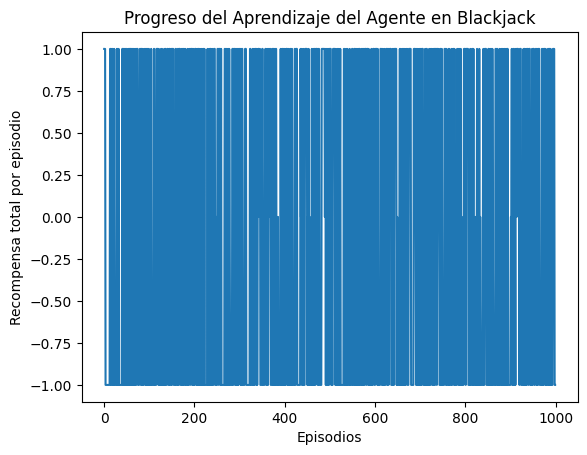

In [ ]:
import matplotlib.pyplot as plt

# Lista para registrar las recompensas por episodio
rewards_per_episode = []

# Entrenar el agente con Q-learning
for episode in range(1000):  # Número de episodios para entrenar
    state, info = env.reset()
    done = False
    total_reward = 0  # Para acumular la recompensa del episodio

    while not done:
        player_sum, dealer_card, usable_ace = state
        action = choose_action(state)

        # Tomar el paso en el entorno y recibir el nuevo estado y recompensa
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Actualizar Q-table usando la ecuación de Q-learning
        if not done:
            next_action = np.argmax(q_table[next_state])
            q_table[state][action] = q_table[state][action] + alpha * (
                reward + gamma * q_table[next_state][next_action] - q_table[state][action]
            )
        else:
            q_table[state][action] = q_table[state][action] + alpha * (reward - q_table[state][action])

        # Acumular recompensa
        total_reward += reward
        # Actualizar el estado
        state = next_state

    # Agregar la recompensa total del episodio a la lista
    rewards_per_episode.append(total_reward)

# Graficar las recompensas por episodio para visualizar el aprendizaje
plt.plot(rewards_per_episode)
plt.xlabel('Episodios')
plt.ylabel('Recompensa total por episodio')
plt.title('Progreso del Aprendizaje del Agente en Blackjack')
plt.show()


In [ ]:
# Imprimir la Q-table
for state, actions in q_table.items():
    print(f"Estado {state}: Palo={actions[0]:.2f}, Golpear={actions[1]:.2f}")


Estado (4, 1, 0): Palo=-0.10, Golpear=-0.03
Estado (4, 1, 1): Palo=0.00, Golpear=0.00
Estado (4, 2, 0): Palo=0.10, Golpear=0.00
Estado (4, 2, 1): Palo=0.00, Golpear=0.00
Estado (4, 3, 0): Palo=0.00, Golpear=0.00
Estado (4, 3, 1): Palo=0.00, Golpear=0.00
Estado (4, 4, 0): Palo=0.00, Golpear=0.00
Estado (4, 4, 1): Palo=0.00, Golpear=0.00
Estado (4, 5, 0): Palo=0.00, Golpear=0.00
Estado (4, 5, 1): Palo=0.00, Golpear=0.00
Estado (4, 6, 0): Palo=0.00, Golpear=0.00
Estado (4, 6, 1): Palo=0.00, Golpear=0.00
Estado (4, 7, 0): Palo=-0.10, Golpear=0.00
Estado (4, 7, 1): Palo=0.00, Golpear=0.00
Estado (4, 8, 0): Palo=-0.10, Golpear=0.00
Estado (4, 8, 1): Palo=0.00, Golpear=0.00
Estado (4, 9, 0): Palo=-0.10, Golpear=0.00
Estado (4, 9, 1): Palo=0.00, Golpear=0.00
Estado (4, 10, 0): Palo=-0.10, Golpear=0.00
Estado (4, 10, 1): Palo=0.00, Golpear=0.00
Estado (5, 1, 0): Palo=-0.10, Golpear=0.00
Estado (5, 1, 1): Palo=0.00, Golpear=0.00
Estado (5, 2, 0): Palo=-0.10, Golpear=0.00
Estado (5, 2, 1): Palo=0

## GRAFICA 2 "Progreso del Aprendizaje del Agente en Blackjack"
Recompensa por episodio - Episodio

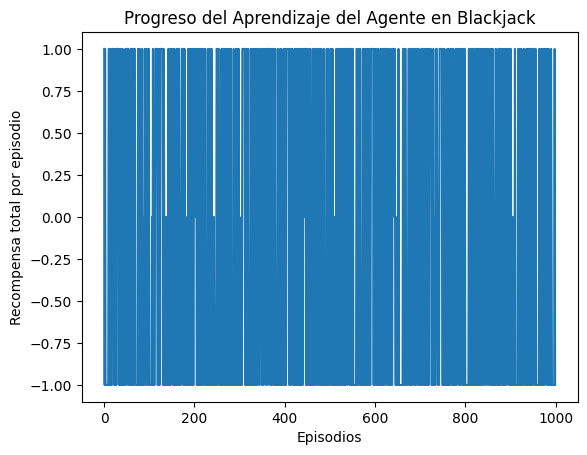

Q-table final:
Estado (4, 1, 0): Palo=0.00, Golpear=0.00
Estado (4, 1, 1): Palo=0.00, Golpear=0.00
Estado (4, 2, 0): Palo=-0.10, Golpear=0.00
Estado (4, 2, 1): Palo=0.00, Golpear=0.00
Estado (4, 3, 0): Palo=0.00, Golpear=0.00
Estado (4, 3, 1): Palo=0.00, Golpear=0.00
Estado (4, 4, 0): Palo=0.00, Golpear=0.00
Estado (4, 4, 1): Palo=0.00, Golpear=0.00
Estado (4, 5, 0): Palo=0.00, Golpear=0.00
Estado (4, 5, 1): Palo=0.00, Golpear=0.00
Estado (4, 6, 0): Palo=0.00, Golpear=0.00
Estado (4, 6, 1): Palo=0.00, Golpear=0.00
Estado (4, 7, 0): Palo=-0.10, Golpear=0.00
Estado (4, 7, 1): Palo=0.00, Golpear=0.00
Estado (4, 8, 0): Palo=0.00, Golpear=0.00
Estado (4, 8, 1): Palo=0.00, Golpear=0.00
Estado (4, 9, 0): Palo=0.00, Golpear=0.00
Estado (4, 9, 1): Palo=0.00, Golpear=0.00
Estado (4, 10, 0): Palo=-0.10, Golpear=0.00
Estado (4, 10, 1): Palo=0.00, Golpear=0.00
Estado (5, 1, 0): Palo=0.00, Golpear=0.00
Estado (5, 1, 1): Palo=0.00, Golpear=0.00
Estado (5, 2, 0): Palo=-0.10, Golpear=0.00
Estado (5, 2,

In [ ]:
import gymnasium as gym
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Inicializar el entorno
env = gym.make("Blackjack-v1", natural=False)

# Parámetros de Q-learning
alpha = 0.1     # Tasa de aprendizaje
gamma = 0.99    # Factor de descuento
epsilon = 0.1   # Tasa de exploración

# Inicializar Q-table con ceros para cada combinación posible de estado y acción
q_table = {}
for player_sum in range(4, 22):
    for dealer_card in range(1, 11):
        for usable_ace in [0, 1]:
            q_table[(player_sum, dealer_card, usable_ace)] = [0, 0]  # Palo, Golpear

# Definir la política de acción (ε-greedy)
def choose_action(state, training=True):
    if training and np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

# Lista para registrar las recompensas por episodio
rewards_per_episode = []

# Entrenar el agente con Q-learning
for episode in range(1000):
    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        player_sum, dealer_card, usable_ace = state
        action = choose_action(state)

        # Tomar el paso en el entorno y recibir el nuevo estado y recompensa
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Actualizar Q-table usando la ecuación de Q-learning
        if not done:
            next_action = np.argmax(q_table[next_state])
            q_table[state][action] = q_table[state][action] + alpha * (
                reward + gamma * q_table[next_state][next_action] - q_table[state][action]
            )
        else:
            q_table[state][action] = q_table[state][action] + alpha * (reward - q_table[state][action])

        total_reward += reward
        state = next_state

    rewards_per_episode.append(total_reward)

# Guardar la Q-table en un archivo
with open("q_table_blackjack.pkl", "wb") as file:
    pickle.dump(q_table, file)

# Graficar las recompensas por episodio
plt.plot(rewards_per_episode)
plt.xlabel('Episodios')
plt.ylabel('Recompensa total por episodio')
plt.title('Progreso del Aprendizaje del Agente en Blackjack')
plt.show()

# Imprimir la Q-table completa
print("Q-table final:")
for state, actions in q_table.items():
    print(f"Estado {state}: Palo={actions[0]:.2f}, Golpear={actions[1]:.2f}")


## GRAFICA 3 "Progreso del Aprendizaje del Agente en Blackjack"
Recompensa Promedio (Promedio móvil)  - Episodio

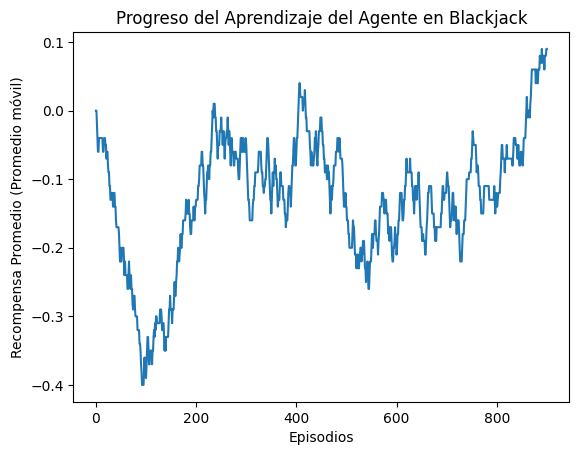

In [ ]:
import gymnasium as gym
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Inicializar el entorno
env = gym.make("Blackjack-v1", natural=False)

# Parámetros de Q-learning
alpha = 0.1     # Tasa de aprendizaje
gamma = 0.99    # Factor de descuento
epsilon = 0.1   # Tasa de exploración

# Inicializar Q-table con ceros para cada combinación posible de estado y acción
q_table = {}
for player_sum in range(4, 22):
    for dealer_card in range(1, 11):
        for usable_ace in [0, 1]:
            q_table[(player_sum, dealer_card, usable_ace)] = [0, 0]  # Palo, Golpear

# Definir la política de acción (ε-greedy)
def choose_action(state, training=True):
    if training and np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

# Lista para registrar las recompensas por episodio
rewards_per_episode = []

# Entrenar el agente con Q-learning
for episode in range(1000):
    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        player_sum, dealer_card, usable_ace = state
        action = choose_action(state)

        # Tomar el paso en el entorno y recibir el nuevo estado y recompensa
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Actualizar Q-table usando la ecuación de Q-learning
        if not done:
            next_action = np.argmax(q_table[next_state])
            q_table[state][action] = q_table[state][action] + alpha * (
                reward + gamma * q_table[next_state][next_action] - q_table[state][action]
            )
        else:
            q_table[state][action] = q_table[state][action] + alpha * (reward - q_table[state][action])

        # Acumular la recompensa
        total_reward += reward
        state = next_state

    # Guardar la recompensa total del episodio
    rewards_per_episode.append(total_reward)


"""
----------------------------------------------------------------------
"""
# Suavizar la recompensa usando un promedio móvil para mejorar la visualización
window_size = 100
smoothed_rewards = np.convolve(rewards_per_episode, np.ones(window_size) / window_size, mode='valid')

# Graficar las recompensas suavizadas por episodio
plt.plot(smoothed_rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio (Promedio móvil)')
plt.title('Progreso del Aprendizaje del Agente en Blackjack')
plt.show()
